## Import Library

In [250]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score,accuracy_score, precision_score, classification_report
from sklearn.tree import DecisionTreeClassifier

## Load Dataset

In [251]:
churn = pd.read_csv("telco_customer_churn.csv")
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [252]:
#Checking hidden missing values
churn["TotalCharges"].loc[churn['TotalCharges'].str.contains(' ')].count()/churn["TotalCharges"].count()*100

0.1561834445548772

Karena data yang hilang hanya 0,15% maka kita akan menghapusnya

In [253]:
# drop white space in TotalCharges
churn = churn.loc[-churn['TotalCharges'].str.contains(' ')]

# Changing dtype to float
churn['TotalCharges'] = churn['TotalCharges'].astype(float)

### Datasets Columns :
```
1. CustomerID = Contains unique values from every customer
2. Gender = Male and Female
3. SeniorCitizen = 1 for yes and 0 for no
4. Partner = Whether the customer has a partner (1) or no (0)
5. Dependents = Whether the customer has dependents or not (Yes, No)
6. tenure = Number of months the customer has stayed with the company
7. PhoneService = Whether the customer has a phone service or not (Yes, No)
8. MultipleLines = Whether the customer has multiple lines or not (Yes, No, No phone service)
9. InternetService = Customer’s internet service provider (DSL, Fiber optic, No)
10. OnlineSecurity = Whether the customer has online security or not (Yes, No, No internet service)
11. OnlineBackup = Whether the customer has online backup or not (Yes, No, No internet service)
12. DeviceProtection = Whether the customer has device protection or not (Yes, No, No internet service)
13. TechSupport = Whether the customer has tech support or not (Yes, No, No internet service)
14. StreamingTV = Whether the customer has streaming TV or not (Yes, No, No internet service)
15. StreamingMovies = Whether the customer has streaming movies or not (Yes, No, No internet service)
16. Contract = The contract term of the customer (Month-to-month, One year, Two year)
17. PaperlessBilling = Whether the customer has paperless billing or not (Yes, No)
18. PaymentMethod = The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
19. MonthlyCharges = The amount charged to the customer monthly
20. TotalCharges = The total amount charged to the customer
21. Churn = Whether the customer churned or not (Yes or No)
```



## Data Split

In [254]:
X = churn.drop("Churn", axis = 1)
y = churn["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Data Train Preprocessing

### Data Train Cleaning

In [255]:
# Check Missing Values
X_train.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [256]:
# Check Duplicates
X_train.duplicated().sum()

0

In [257]:
X_train.drop(columns=['customerID'], inplace=True)

In [258]:
#Checking non_numerik type
non_numerik = X_train.select_dtypes(exclude=["number"]).columns.tolist()
non_numerik

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Since we will not use CustomerID, we gonna drop the column

### Data Train Encoding

#### Label Encoding

In [259]:
from sklearn.preprocessing import LabelEncoder

# List of columns that need encoding (categorical variables)
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'OnlineBackup', 'PaperlessBilling']

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    X_train[col] = le.fit_transform(X_train[col])

#### Ordinal Encoding

In [260]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

ordinal_columns = ['Contract']
ordinal_encoder = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])
X_train[ordinal_columns] = ordinal_encoder.fit_transform(X_train[ordinal_columns])

#### One-Hot Decoding

In [261]:
InternetHot = pd.get_dummies(X_train['InternetService'],prefix='IS')
InternetHot = InternetHot.astype(int)
PaymentHot = pd.get_dummies(X_train['PaymentMethod'],prefix='PM')
PaymentHot = PaymentHot.astype(int)

In [262]:
X_train = pd.concat([X_train, InternetHot, PaymentHot], axis=1)
X_train.drop('InternetService', axis=1, inplace=True)
X_train.drop('PaymentMethod', axis=1, inplace=True)
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,IS_DSL,IS_Fiber optic,IS_No,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check
6030,0,0,0,0,43,0,1,0,0,2,...,1,49.05,2076.20,1,0,0,1,0,0,0
3410,1,0,0,0,3,1,0,0,0,0,...,0,53.40,188.70,1,0,0,0,1,0,0
5483,0,0,1,0,55,1,2,0,0,2,...,1,77.75,4458.15,0,1,0,0,0,1,0
5524,1,0,1,1,45,1,0,2,0,0,...,0,54.65,2553.70,1,0,0,1,0,0,0
6337,0,0,1,1,55,1,2,2,0,0,...,0,100.90,5448.60,0,1,0,0,0,0,1


<Axes: ylabel='TotalCharges'>

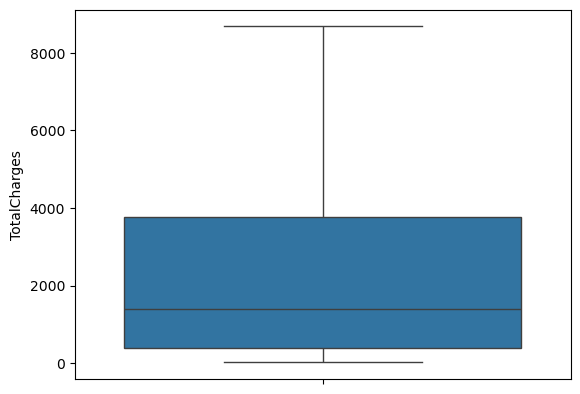

In [263]:
# Checking Outliers
sns.boxplot(X_train["TotalCharges"])

In [264]:
#checking dtype after transformation
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 6030 to 862
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        5625 non-null   int32  
 1   SeniorCitizen                 5625 non-null   int64  
 2   Partner                       5625 non-null   int32  
 3   Dependents                    5625 non-null   int32  
 4   tenure                        5625 non-null   int64  
 5   PhoneService                  5625 non-null   int32  
 6   MultipleLines                 5625 non-null   int32  
 7   OnlineSecurity                5625 non-null   int32  
 8   OnlineBackup                  5625 non-null   int32  
 9   DeviceProtection              5625 non-null   int32  
 10  TechSupport                   5625 non-null   int32  
 11  StreamingTV                   5625 non-null   int32  
 12  StreamingMovies               5625 non-null   int32  
 13  Contra

In [265]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

### Data Train Balancing

In [266]:
from imblearn import over_sampling

# SMOTE technique for training data
X_train_balanced, y_train_balanced = over_sampling.SMOTE().fit_resample(X_train, y_train)

In [267]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

## Data test Preprocessing

### Data Train Cleaning

In [268]:
X_test.drop(columns=['customerID'], inplace=True)

In [269]:
# Check Missing Values
X_test.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

### Data Test Encoding

In [270]:
# List of columns that need encoding (categorical variables)
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'OnlineBackup', 'PaperlessBilling']

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    X_test[col] = le.fit_transform(X_test[col])

In [271]:
le = LabelEncoder()

y_test = le.fit_transform(y_test)

In [272]:
ordinal_columns = ['Contract']
ordinal_encoder = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])
X_test[ordinal_columns] = ordinal_encoder.fit_transform(X_test[ordinal_columns])

In [273]:
InternetHot = pd.get_dummies(X_test['InternetService'],prefix='IS')
InternetHot = InternetHot.astype(int)
PaymentHot = pd.get_dummies(X_test['PaymentMethod'],prefix='PM')
PaymentHot = PaymentHot.astype(int)

In [274]:
X_test = pd.concat([X_test, InternetHot, PaymentHot], axis=1)
X_test.drop('InternetService', axis=1, inplace=True)
X_test.drop('PaymentMethod', axis=1, inplace=True)
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,IS_DSL,IS_Fiber optic,IS_No,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check
2481,1,1,1,0,61,1,2,1,1,1,...,0,25.00,1501.75,0,0,1,1,0,0,0
6784,0,0,0,0,19,1,2,1,1,1,...,0,24.70,465.85,0,0,1,1,0,0,0
6125,1,0,1,0,13,1,2,0,0,2,...,1,102.25,1359.00,0,1,0,0,1,0,0
3052,1,0,1,0,37,1,2,2,0,0,...,1,55.05,2030.75,1,0,0,0,0,0,1
4099,0,0,0,0,6,0,1,2,0,0,...,0,29.45,161.45,1,0,0,1,0,0,0


<Axes: xlabel='TotalCharges', ylabel='Density'>

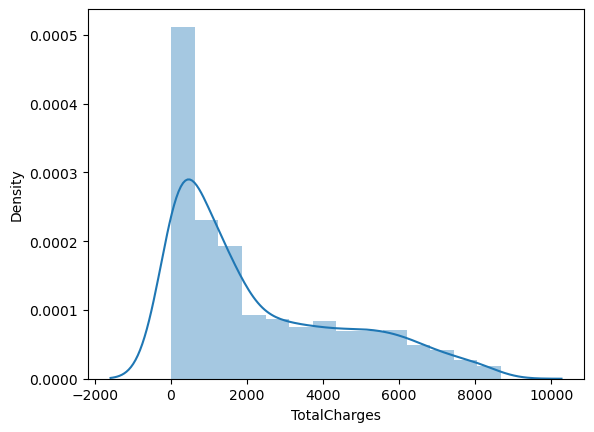

In [275]:
sns.distplot(X_test["TotalCharges"])

<Axes: ylabel='TotalCharges'>

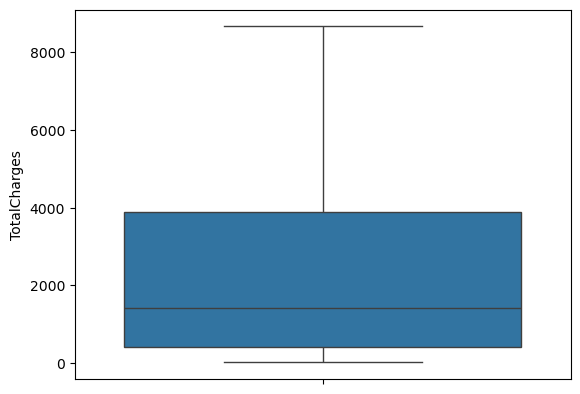

In [276]:
sns.boxplot(X_test["TotalCharges"])

## Model Training

### Random Forest

In [277]:
randomFor = RandomForestClassifier(random_state=42)
randomFor.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

### Random Forest Imbalance

In [278]:
random_imbalance = RandomForestClassifier(random_state=42)
random_imbalance.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Decision Tree

In [279]:
# Train Decision Tree Model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(random_state=42)

### Logistic Regression

In [280]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)

LogisticRegression(random_state=42)

## Model Evaluation
Untuk Evaluasi akan menggunakan Precision, karena kita perlu aware dan menekankan kepada Churn = Yes, sehingga kita perlu memperhatikan akurasi terhadap False Positive.

### Random Forest

In [281]:
#Evaluate using validation data
random_pred = randomFor.predict(X_val)


# Evaluate the model
print('Precision Random Forest data validation =',precision_score(y_val, random_pred, pos_label=1))
print('Precision Random Forest data validation =',precision_score(y_val, random_pred, pos_label=0))

#Evaluate using Test data
random_pred = randomFor.predict(X_test)

# Evaluate the model
print('Precision Random Forest data test =',precision_score(y_test, random_pred, pos_label=1))
print('Precision Random Forest data test =',precision_score(y_test, random_pred, pos_label=0))



Precision Random Forest data validation = 0.9987966305655837
Precision Random Forest data validation = 1.0
Precision Random Forest data test = 0.5621468926553672
Precision Random Forest data test = 0.8338081671415005


Dapat kita lihat bahwa akurasi data serta ketepatan TP dan TN sangat tinggi dalam memprediksi validasi data (sudah di balancing), namun untuk memprediksi data test hasilnya adalah : 
- TP = 58% dan FP = 42% 
- TN = 84% dan FN = 16%

Cukup tinggi untuk False Positifnya, performa untuk menemukan customer Churn tidak cukup baik untuk data real.
Atau model tersebut terdiagnosa mengalami Overfitting

### Random Forest Imbalance Data

In [282]:
#Evaluate using real test data
rnd_forest_imba = random_imbalance.predict(X_test)

# Evaluate the model
print('Precision Random Forest imbalance data =',precision_score(y_test, rnd_forest_imba, pos_label=1))
print('Precision Random Forest imbalance data =',precision_score(y_test, rnd_forest_imba, pos_label=0))

Precision Random Forest imbalance data = 0.6070175438596491
Precision Random Forest imbalance data = 0.820855614973262


### Decision Tree

In [283]:
# Make predictions on the validation set
y_pred = clf.predict(X_val)

# Evaluate the model
print('Precision Decision Tree data Val =',precision_score(y_val, y_pred, pos_label=1))
print('Precision Decision Tree data Val =',precision_score(y_val, y_pred, pos_label=0))

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print('Precision Decision Tree data test =',precision_score(y_test, y_pred, pos_label=1))
print('Precision Decision Tree data test =',precision_score(y_test, y_pred, pos_label=0))

Precision Decision Tree data Val = 1.0
Precision Decision Tree data Val = 1.0
Precision Decision Tree data test = 0.4860759493670886
Precision Decision Tree data test = 0.8201581027667985


### Logistic Regression

In [284]:
# Make predictions on the validation set
y_pred_reg = logreg.predict(X_val)

# Evaluate the model
print('Precision Logistic Regression data val =',precision_score(y_val, y_pred_reg, pos_label=1))
print('Precision Logistic Regression data val =',precision_score(y_val, y_pred_reg, pos_label=0))

y_pred_reg = logreg.predict(X_test)

# Model Evaluation
print('Precision Logistic Regression data test =',precision_score(y_test, y_pred_reg, pos_label=1))
print('Precision Logistic Regression data test =',precision_score(y_test, y_pred_reg, pos_label=0))

Precision Logistic Regression data val = 0.792147806004619
Precision Logistic Regression data val = 0.816793893129771
Precision Logistic Regression data test = 0.5050100200400801
Precision Logistic Regression data test = 0.8656387665198237


## Summary

- Model terbaik akan ditentukan berdasarkan **performa dalam prediksi data test** bukan data val!
- **Precision akan menjadi metric evaluasi** terpilih karena khawatir terhadap False Positif **(Customer akan Churn dianggap tidak)**
- Model terbaik ditentukan berdasarkan **nilai Precision untuk TP tertinggi** (FP terendah), dikarenakan model akan memprediksi Churn = 1, maka diperlukan model dengan performa True Positif tertinggi **(prediksi tepat menebak customer yang churn)**


In [287]:
print('Precision Logistic Regression TP=',precision_score(y_test, y_pred_reg, pos_label=1))
print('Precision Decision Tree TP=',precision_score(y_test, y_pred, pos_label=1))
print('Precision Random Forest Imbalance TP=',precision_score(y_test, rnd_forest_imba, pos_label=1))
print('Precision Random Forest TP=',precision_score(y_test, random_pred, pos_label=1))

Precision Logistic Regression TP= 0.5050100200400801
Precision Decision Tree TP= 0.4860759493670886
Precision Random Forest Imbalance TP= 0.6070175438596491
Precision Random Forest TP= 0.5621468926553672


Dari Hasil diatas, maka Random Forest tanpa Balancing Data menjadi Model terbaik dengan Precision True Positif = 61%